# Exercise 5: Extracting dynamical systems from data.
<br>

# Table of contents <a name="toc"></a>
1. [Task 1](#task1) <br>
    1.1. [Q1](#q1) <br>
    1.2. [Q2](#q2) <br>
    1.3. [Q3](#q3) <br>
2. [Task 2](#task2)<br>
    2.1. [Q1](#q21)<br>
    2.2. [Q2](#q22)<br>

## Task 1. Approximating functions. <a name="task1"></a>

In [1]:
import numpy as np
import pandas as pd

First, we shall obtain and visualize the data.

In [10]:
def get_func_data(filename):
    xs = list()
    ys = list()
    with open(filename) as f:
        line = f.readline()
        while(line):
            try:
                x,y = str(line).split(" ")
            except:
                print(line)
            xs.append(float(x))
            ys.append(float(y))
            line = f.readline()
    return xs, ys

In [13]:
linear_xs, linear_ys = get_func_data("linear_function_data.txt")

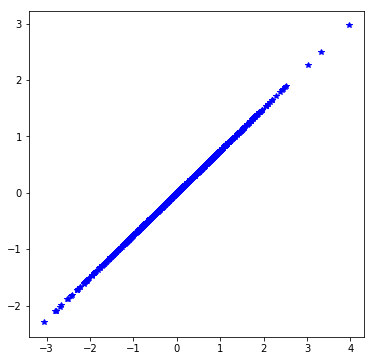

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(linear_xs, linear_ys, "*b")
plt.show()

In [20]:
nonlinear_xs, nonlinear_ys = get_func_data("nonlinear_function_data.txt")

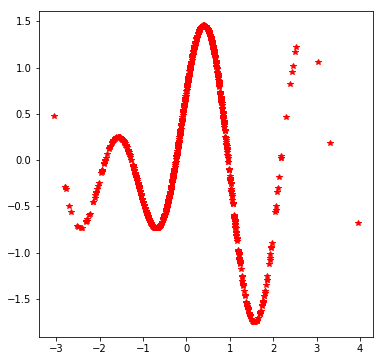

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(nonlinear_xs, nonlinear_ys, "*r")
plt.show()

### Q1: Approximating linear function. <a name="q1"></a>
[go to TOC](#toc) <br>
We assume that we are dealing with a linear function that can be expressed as
$$ \hat{f}_{linear} = Ax \in \mathbb{R}^d$$
In our case, we are talking about one-dimensional vectors, so $d=1$. As per section (1.1) of the theory part of the exercise, if we have a set $\mathbb{X}$ of $N$ observations and a set of $\mathbb{F}$ of their corresponding values (obtained after applying a linear function to $\mathbb{X}$), than we can approximate the matrix $A$ as follows:
$$ A^T = (\mathbb{X}^T\mathbb{X})^{-1}\mathbb{X}^T\mathbb{F}$$
which is a solution for the problem 
$$min_A||\mathbb{F} - \mathbb{X}A^T|| $$
We will use numpy.linalg.lstsq to compute it - following the good principle of using good, optimized and tested code if it exists and suits our purposes.
Basically, our case is the same thing as the example in [numpy.linalg.lstsq docs](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html). We have:
$$y = mx + c$$ and wish to find $m,c$. Let us follow in their footsteps.

In [24]:
import numpy as np

A = np.vstack([linear_xs, np.ones(len(linear_xs))]).T

m, c = np.linalg.lstsq(A, linear_ys, rcond=None)[0]

f_hat = np.dot(m, linear_xs) + c

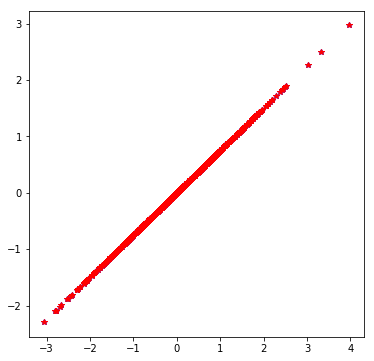

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(linear_xs, linear_ys, "*b")
plt.plot(linear_xs, f_hat, "*r")
plt.show()

As we can see, since the initial data is almost perfectly linear, our approximation is virtually perfect, Let's try with non-linear data now.

### Q2: Approximating nonlinear data using linear function. <a name="q2"></a>
[go to TOC](#toc) <br>


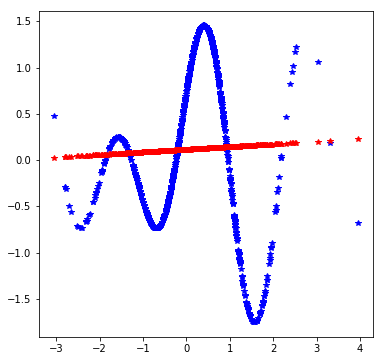

In [27]:
import numpy as np
import matplotlib.pyplot as plt

A = np.vstack([nonlinear_xs, np.ones(len(nonlinear_xs))]).T

m, c = np.linalg.lstsq(A, nonlinear_ys, rcond=None)[0]

f_hat = np.dot(m, nonlinear_xs) + c

plt.figure(figsize=(6,6))
plt.plot(nonlinear_xs, nonlinear_ys, "*b")
plt.plot(nonlinear_xs, f_hat, "*r")
plt.show()

As expected, we cannot really approximate a curve with a straight line. The red line tries its best (intuitively it is obvious) but it is not, of course, enough. Let us see how a combination of radial functions will do.

### Q3: Approximating nonlinear data using a combination of radial functions. <a name="q3"></a>
[go to TOC](#toc) <br>


First order of business is to choose the basis of radial functions. We know that:
a) If we pick as many basis functions as we have data points, we can represent them perfectly
b) we may have problems with generalization and interpolation if we do that
We see that we are dealing with data points on $~[-3, 4]$ interval. We have 1000 data points. Let's split this interval into 200 parts and center our basis functions around those points.

In [122]:
central_points = np.linspace(-3, 4, 200)

We are to solve the following minimization problem: 
$$ min_C||\mathbb{F} - \phi(\mathbb{X})C^T|| $$
where 
$$\phi(\mathbb{X}) := (\phi_1(X), ..., \phi_L(X))^T \in \mathbb{R}^{NxL} $$
Once again, this is a problem of least-squares minimization with only one unknown (matrix $C \in \mathbb{R}^{1xL}$).
So, let us construct $\phi(\mathbb{X})$

In [123]:
import numpy as np

def phi_l(xl, eps, x):
    return np.exp(-(xl-x)**2/eps**2)

def construct_phi_matrix(xvals, eps, central_points):
    result = np.empty((xvals.size, central_points.size))
    for xl_indx in range(central_points.size):
        for point_indx in range(xvals.size):
            result[point_indx, xl_indx] = phi_l(central_points[xl_indx], eps, xvals[point_indx])
    return result


In [124]:
phi_mtrx = construct_phi_matrix(np.array(nonlinear_xs), 0.1, central_points)
phi_mtrx.shape

(1000, 200)

Great, now let us try least-square minimization again.

In [125]:
C = np.linalg.lstsq(phi_mtrx, nonlinear_ys, rcond=None)[0]

In [126]:
C.size

200

Ok, now let us see if we can approximate well our function.

In [127]:
f_hat = np.dot(phi_mtrx, C)
f_hat.shape

(1000,)

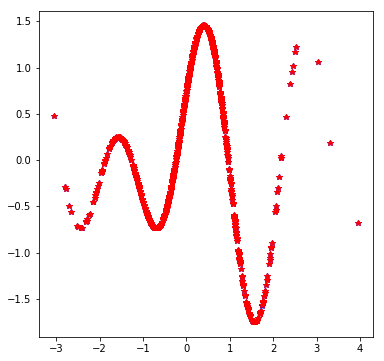

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(nonlinear_xs, nonlinear_ys, "*b")
plt.plot(nonlinear_xs, f_hat, "*r")
plt.show()

Looks good! Let's wrap all this stuff into a class and experiment a bit with epsilons and number of basis functions.

In [129]:
import numpy as np 

class Phi_approximation:
    
    def __init__(self, eps = 0.1, centers = range(10)):
        self.centers = centers
        self.eps     = eps
    
    def set_centers(self, central_points):
        self.centers = central_points
        return True
    
    def phi_l(self, xl, eps, x):
        return np.exp(-(xl-x)**2/eps**2)
    
    def construct_phi_matrix(self, xvals):
        self.phi_mtrx = np.empty((xvals.size, self.centers.size))
        for xl_indx in range(self.centers.size):
            for point_indx in range(xvals.size):
                self.phi_mtrx[point_indx, xl_indx] = self.phi_l(self.centers[xl_indx], self.eps, xvals[point_indx])
        return True
    
    def fit(self, yvals):
        self.C = np.linalg.lstsq(self.phi_mtrx, yvals, rcond=None)[0]
        
    def predict(self):
        return np.dot(self.phi_mtrx, self.C)
    
    def fit_predict(self, xvals, yvals):
        npx = np.array(xvals)
        npy = np.array(yvals)
        self.construct_phi_matrix(npx)
        self.fit(npy)
        return self.predict()
        

Looks good, let's test it out!

In [130]:
pa = Phi_approximation(eps=0.01, centers = np.linspace(-2, 1.5, 200))
preds = pa.fit_predict(nonlinear_xs, nonlinear_ys)

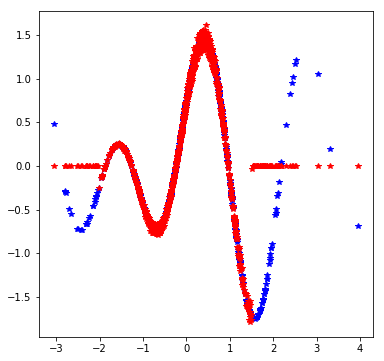

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(nonlinear_xs, nonlinear_ys, "*b")
plt.plot(nonlinear_xs, preds, "*r")
plt.show()

Looks good to me. Let us see how the quality of approximation changes as we increase the number of base functions.

approx. by 1 basis functions


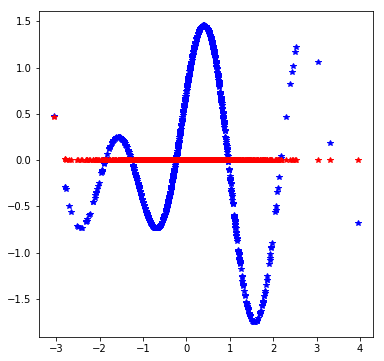

approx. by 5 basis functions


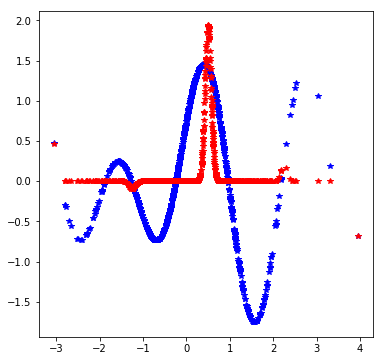

approx. by 10 basis functions


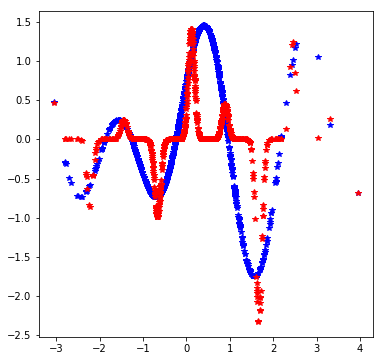

approx. by 20 basis functions


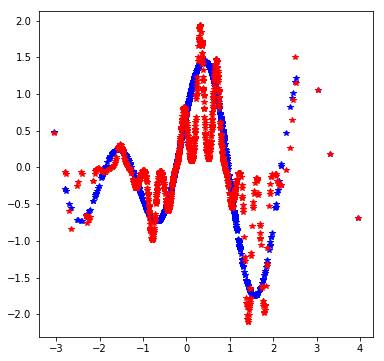

approx. by 30 basis functions


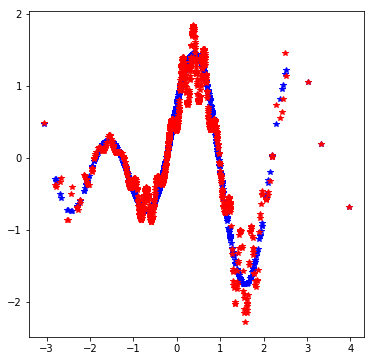

approx. by 50 basis functions


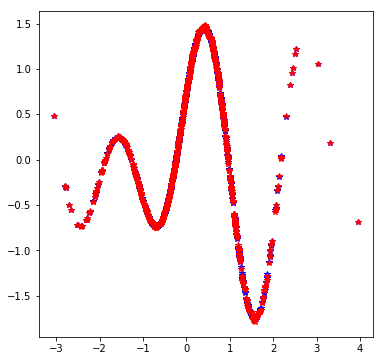

approx. by 60 basis functions


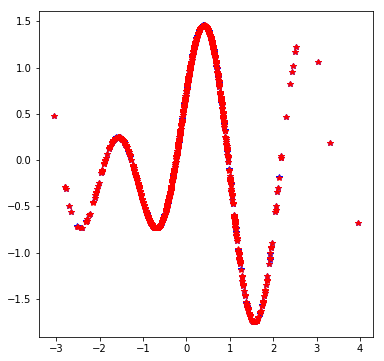

In [143]:
for nfuncs in [1, 5, 10, 20, 30, 50, 60]:
    print("approx. by " + str(nfuncs) + " basis functions")
    pa = Phi_approximation(eps=0.1, centers = np.linspace(-3, 4, nfuncs))
    preds = pa.fit_predict(nonlinear_xs, nonlinear_ys)
    plt.figure(figsize=(6,6))
    plt.plot(nonlinear_xs, nonlinear_ys, "*b")
    plt.plot(nonlinear_xs, preds, "*r")
    plt.show()


Let us analyze these plots. First, we see that up from 50 basis functions we have an almost perfect approximation of the initial function. Second, we must consider the influence of the epsilon value.

Epsilon represents bandwidth, i.e. defines the scope of the influence of each basis function on the final plot. Therefore, it stands to reason to choose epsilon $$ \epsilon \sim \frac{interval \ length}{nfuncs}$$
We tried $\epsilon = 0.1$ with interval of 7 and $\sim$100 points and good results, which makes sense. Let's demonstrate what happens if epsilon is too small.

approx. by 1 basis functions


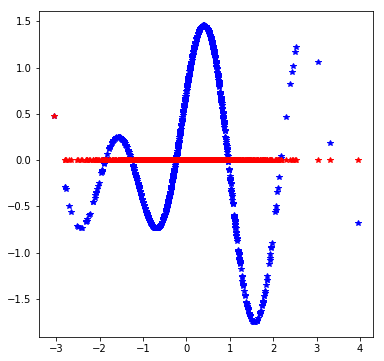

approx. by 5 basis functions


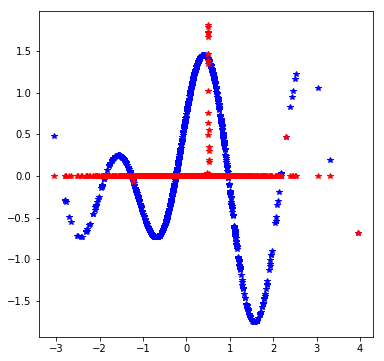

approx. by 10 basis functions


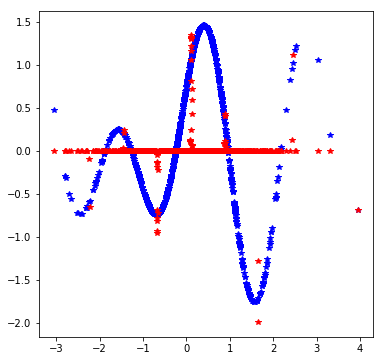

approx. by 20 basis functions


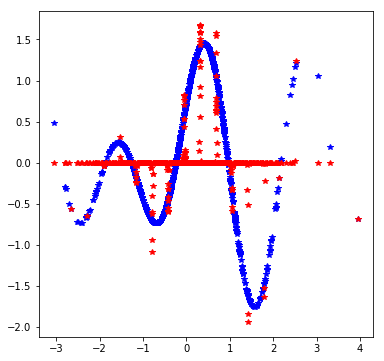

approx. by 30 basis functions


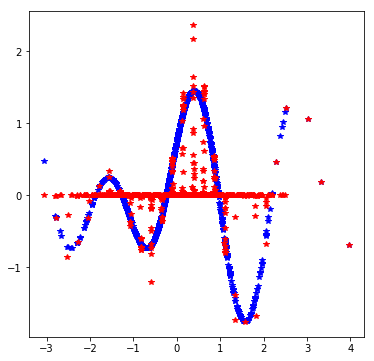

approx. by 50 basis functions


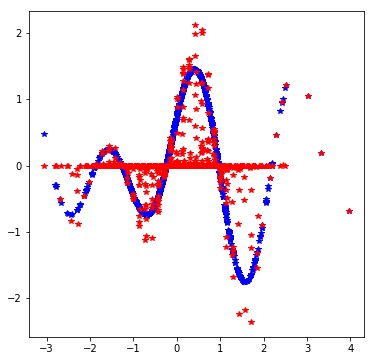

approx. by 60 basis functions


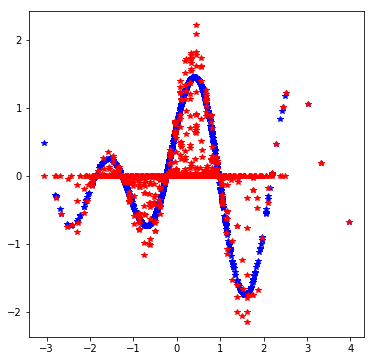

In [145]:
for nfuncs in [1, 5, 10, 20, 30, 50, 60]:
    print("approx. by " + str(nfuncs) + " basis functions")
    pa = Phi_approximation(eps=0.01, centers = np.linspace(-3, 4, nfuncs))
    preds = pa.fit_predict(nonlinear_xs, nonlinear_ys)
    plt.figure(figsize=(6,6))
    plt.plot(nonlinear_xs, nonlinear_ys, "*b")
    plt.plot(nonlinear_xs, preds, "*r")
    plt.show()


These amounts of basis functions are just not enough. However, if we add more of them, it should work better.

approx. by 200 basis functions


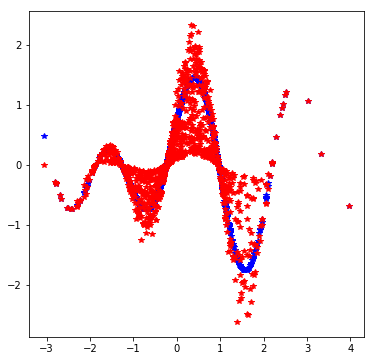

approx. by 300 basis functions


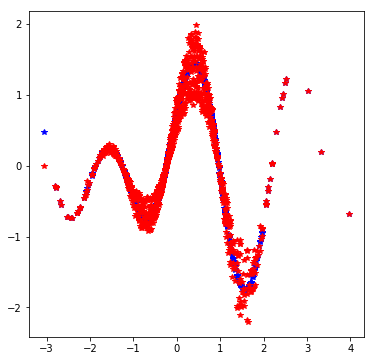

approx. by 400 basis functions


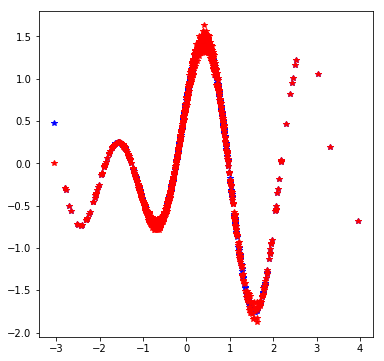

In [146]:
for nfuncs in [200, 300, 400]:
    print("approx. by " + str(nfuncs) + " basis functions")
    pa = Phi_approximation(eps=0.01, centers = np.linspace(-3, 4, nfuncs))
    preds = pa.fit_predict(nonlinear_xs, nonlinear_ys)
    plt.figure(figsize=(6,6))
    plt.plot(nonlinear_xs, nonlinear_ys, "*b")
    plt.plot(nonlinear_xs, preds, "*r")
    plt.show()

There we go. So, to sum up, **the choice of epsilon depends on the number of radial functions we use and the length of the interval we are approximating on**. It is obvious from the definition of a radial function - the bigger the epsilon, the bigger interval is affected by it.

Let's try approximating linear data with radial functions.

approx. by 200 basis functions


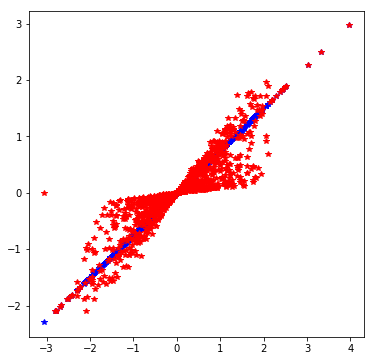

approx. by 300 basis functions


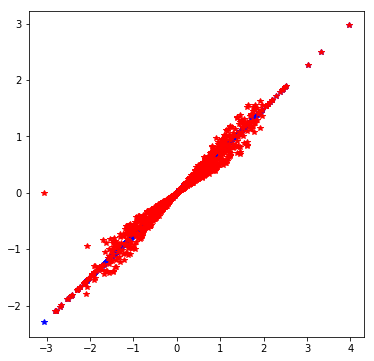

approx. by 400 basis functions


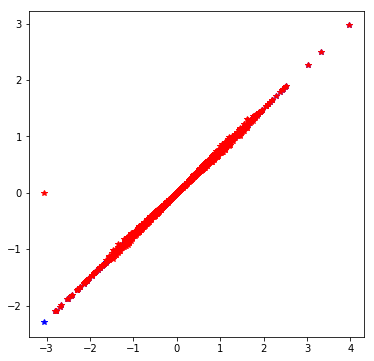

In [148]:
for nfuncs in [200, 300, 400]:
    print("approx. by " + str(nfuncs) + " basis functions")
    pa = Phi_approximation(eps=0.01, centers = np.linspace(-3, 4, nfuncs))
    preds = pa.fit_predict(linear_xs, linear_ys)
    plt.figure(figsize=(6,6))
    plt.plot(linear_xs, linear_ys, "*b")
    plt.plot(linear_xs, preds, "*r")
    plt.show()

Still works, as we can see. However, it is not a good idea to use radial functions with linear data because it is a way overcomplicated solution for this type of data. Also, in general linear approximation on linear data will probably give better results than radial approximation (duh :) ). Or, at least, we will definitely need to unnecessarily use a lot of basis functions. 

## Task 2: Approximating linear vector fields <a name="task2"></a>

[go to TOC](#toc) <br>
Let's first get the data in.

In [1]:
import numpy as np

linear_x0 = np.empty((1000,2))
linear_x1 = np.empty((1000,2))

with open("linear_vectorfield_data_x0.txt") as f:
    line = f.readline()
    cnt = 0
    while line:
        x01, x02 = str(line).split(" ")
        linear_x0[cnt, 0] = float(x01)
        linear_x0[cnt, 1] = float(x02)
        cnt = cnt + 1
        line = f.readline()
        
with open("linear_vectorfield_data_x1.txt") as f:
    line = f.readline()
    cnt = 0
    while line:
        x11, x12 = str(line).split(" ")
        linear_x1[cnt, 0] = float(x11)
        linear_x1[cnt, 1] = float(x12)
        cnt = cnt + 1
        line = f.readline()        
        

### Q1: Linear vector field estimation <a name="q21"></a>
[go to TOC](#toc) <br>
Here we suppose that 
$$\hat{v}^{(k)} = \frac{x_1^{(k)} - x_0^{(k)}}{\Delta t}$$
Using this formula and the given data, we can estimate $\hat{v}^{(k)} \ \  \forall k$. Once we have that, we will estimate matrix $\mathbb{A}$ - solution to the following problem:
$$ \hat{v}^{(k)} = \mathbb{A}x_0^{(k)}$$
Sounds like a plan. How, however, should we choose $\Delta t$ for our first approximation? Let's visualize the difference between x0 and x1.

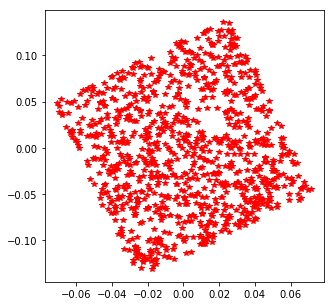

In [6]:
import matplotlib.pyplot as plt

diff = (linear_x1 - linear_x0)
plt.figure(figsize=(5,5))
plt.plot(diff[:,0], diff[:,1], "*r")
plt.show()

So, we can safely say that the differences are pretty small. In that case, if x1 and x0 are respectively the initial and the final vectors, then $x_1^{(k)} - x_0^{(k)}$ gives us the approximate direction of $\hat{v}^{(k)}$, and $\Delta t$ determines it's magnitude.
Let's see what that magnitude would be in general if $\Delta t$ was 1.

In [7]:
magn = np.sqrt(diff[:, 1]**2 + diff[:,0]**2)

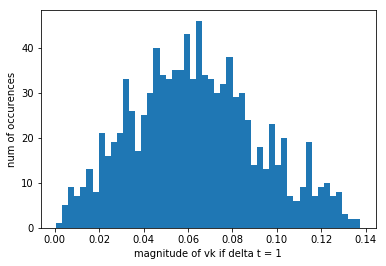

In [11]:
plt.hist(magn, bins=50)
plt.xlabel("magnitude of vk if delta t = 1")
plt.ylabel("num of occurences")
plt.show()

Let's see how that compares to magnitudes of initial vectors.

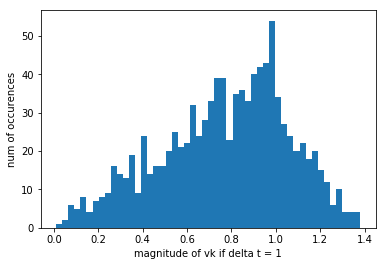

In [13]:
magnx0 = np.sqrt(linear_x0[:, 1]**2 + linear_x0[:,0]**2)
plt.hist(magnx0, bins=50)
plt.xlabel("magnitude of vk if delta t = 1")
plt.ylabel("num of occurences")
plt.show()

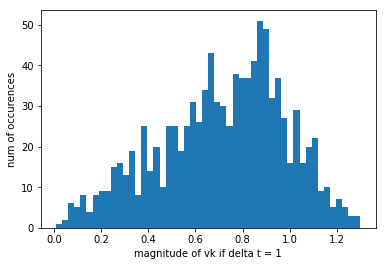

In [14]:
magnx1 = np.sqrt(linear_x1[:, 1]**2 + linear_x1[:,0]**2)
plt.hist(magnx1, bins=50)
plt.xlabel("magnitude of vk if delta t = 1")
plt.ylabel("num of occurences")
plt.show()

Ok, so let's say that $\Delta t$ was 0.1 - seems reasonable, we don't want the magnitudes to be much different, and also in question 2 this is the delta t value used, so makes sense to use it straight away.

In [15]:
approx_vk = (linear_x1 - linear_x0)/0.1

Now let's estimate the matrix $\mathbb{A}$. We can try using least-square method that we employed earlier. Note that $x_0^T\mathbb{A} = \hat{v}^T$

In [16]:
A = np.linalg.lstsq(linear_x0, approx_vk, rcond=None)[0]

In [21]:
linear_x0.shape

(1000, 2)

In [23]:
error = linear_x0 @ A - approx_vk
magnError = np.sqrt(error[:, 1]**2 + error[:,0]**2)
sum(magnError)/error.size

4.733891025392551e-08

Ok, looks good. Let's move on to the second part.

### Q2: Estimating x1 from initial positions and transformation matrix <a name="q22"></a>
[go to TOC](#toc) <br>

We have the following equation:
$$ \dot{x} = \mathbb{A}x \ \ \ \ \ \ (1)$$
We have $\mathbb{A}$ and the initial positions $x_0$. In order to solve this, we will use the scipy python package or, more precisely, the solve_ivp function [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) is it's documentation. We could get smart and try to solve everything manually, but we will stick to the principle of using good, tested and optimized code.

In [35]:
from scipy.integrate import solve_ivp

def right_handside(t, y): return A@y

results = np.empty((1000,2))
for i in range(1000):
    solution = solve_ivp(right_handside, [0, 0.1], linear_x0[i,:], t_eval = [0.1]).y
    results[i, 0] = solution[0]
    results[i, 1] = solution[1]
results

array([[-0.17688678,  0.39662104],
       [-0.93406938, -0.38060697],
       [-0.6369426 , -0.75571755],
       ...,
       [ 0.568651  , -0.08255849],
       [-0.62936177,  0.58348994],
       [-0.93089697,  0.79121337]])

Let's compute the sum of all squared errors as requested in the task. 

In [37]:
sum((results - linear_x1)**2)

array([1.52110187, 1.53882573])

This means that the mean squared error of an individual data point is about 0.0015. Is that good? Let's compute a more meaningful metric - mean $\frac{(\hat{x_1} - x_1)^2}{x_1}$

In [38]:
sum((results-linear_x1)**2/linear_x1)/1000

array([0.00505205, 0.00083841])

So, in general, we get about 0.5% error. Which sounds pretty good to me.

### Q3 The journey from far, far away... <a name="q23"></a>
[go to TOC](#toc)

We will track the journey of a dot that starts at (10,10).

In [60]:
from scipy.integrate import solve_ivp
import numpy as np

def right_handside(t, y): return A@y

journey = np.empty((10000, 2))
current_position = np.array([10.0, 10.0])
for i in range(10000):
    journey[i, :] = current_position.T
    solution = solve_ivp(right_handside, [0.01*i, 0.01*(i+1)], current_position, t_eval = [0.01*(i+1)]).y
    current_position[0] = solution[0]
    current_position[1] = solution[1]

In [62]:
journey

array([[ 1.00000000e+01,  1.00000000e+01],
       [ 9.90466591e+00,  9.92768940e+00],
       [ 9.81013466e+00,  9.85584867e+00],
       ...,
       [ 1.78504238e-31, -1.17429251e-31],
       [ 1.78165169e-31, -1.15898771e-31],
       [ 1.77820724e-31, -1.14383662e-31]])

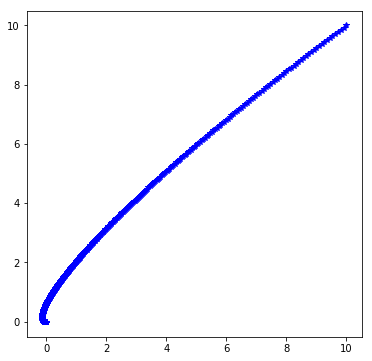

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(journey[:,0], journey[:,1], "*b")
plt.show()

Ok, that definetely looks like a smooth and quasi-linear trajectory. Feels just right. However, let us also visualize the phase portrait of the system just to be sure (will also look pretty good!)

In [64]:
A

array([[-0.49355245, -0.4638232 ],
       [ 0.23191153, -0.95737573]])

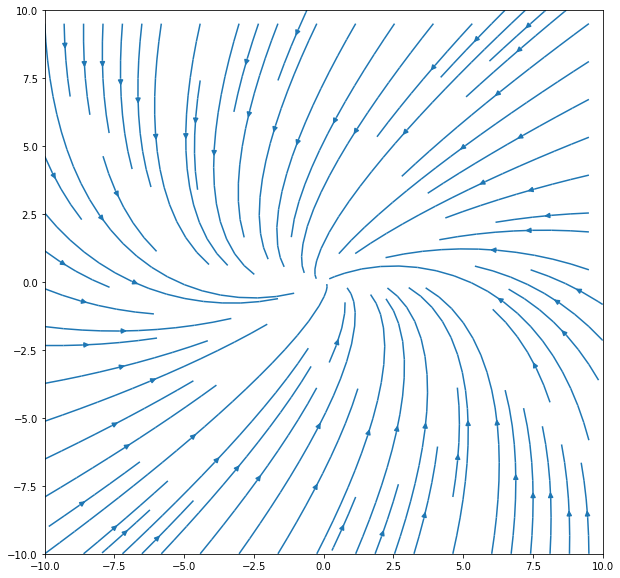

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def compute_x_coordinates(X, Y):
    return X*-0.49355245 + Y*-0.4638232

def compute_y_coordinates(X, Y):
    return X*0.23191153 + Y*-0.95737573

def return_streamplot_params(gridrange):
    # define a grid for visualization
    Y, X = np.mgrid[-gridrange:gridrange:100j, -gridrange:gridrange:100j]

    # define and fill out grid values using the function created above
    X_vals = compute_x_coordinates(X, Y)
    Y_vals = compute_y_coordinates(X, Y)
    
    return X, Y, X_vals, Y_vals

fig = plt.figure(figsize=(10,10))
X, Y, X_vals, Y_vals = return_streamplot_params(10)
plt.streamplot(X, Y, X_vals, Y_vals)
plt.show()

Pretty. Let's add our trajectory, see if it looks cool.

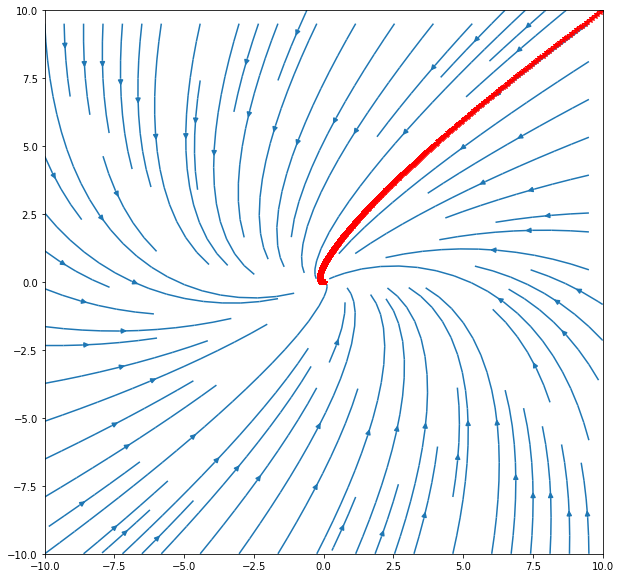

In [69]:
fig = plt.figure(figsize=(10,10))
X, Y, X_vals, Y_vals = return_streamplot_params(10)
plt.streamplot(X, Y, X_vals, Y_vals)
plt.plot(journey[:,0], journey[:,1], "*r")
plt.show()

Perfect. I believe